# 2 - Algorithm Experiments

In [3]:
import numpy as np 
import pandas as pd
from utils import load_data, get_hp_combs
from utils import calc_acc, five_fold_CV
from utils import get_prediction_errors, calc_f1, calc_precision, calc_recall
from svm import SVM
from logistic_reg import LogisticRegression
import matplotlib.pyplot as plt
from decimal import Decimal

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [81]:
classes = [1, 0]
X_train, Y_train, _ = load_data(classes, dir="data/train.csv")
X_test, Y_test, _ = load_data(classes, dir="data/test.csv")

# Hyper Parameter Settings
L_RATES = np.power(np.ones(5)*10, -np.arange(5))
REGS = np.power(np.ones(6)*10, np.arange(-4, 2))
TRADEOFF = np.power(np.ones(6)*10, np.arange(-1, 5))
EPOCHS=50 # For demonstrating classifier class and getting Loss function plots.
CV_EPOCHS=50 # For reducing training runtimes.

# 5 Fold Split Data
ff_data = [load_data(classes, dir=f"data/CVSplits/training0{i}.csv")[:-1] for i in range(5)]
labels = [-1, 1]

## 2.1 - SVM Implementation Experiments

### Implementation Details

I implemented a class in the file svm.py to represent my SVM classifier. I instantiated the weights to be random values such that -1e-8 $\leq w \leq$ 1e-8 . The dataset was shuffled at each epoch and I used a decaying learning rate $r_{t+1}= r_t / (1+t)$ . The Stochastic Sub-Gradient Descent algorithm was used to minimize the hinge loss function as presented in lecture. The bias term was located at the beginning of the weight vector and ones were inserted into the beginning of the input data matrix to allow implicit calculations w/ the bias term. My SVM assumed a regularized average hinge loss, so the loss at each epoch was calculated as $L = 1/n * \Sigma (max(0, 1 - y (w^T x))) + 0.5 * \| w \|^2$ .

### Demo - SVM Class

In [72]:
# simple svm demo
labels = [-1, 1]
model = SVM(labels, r=L_RATES[1], C=REGS[1], epochs=10, exit_on_converge=False)
loss = model.train(X_train, Y_train)

In [73]:
# print accuracy on testing set.
acc = calc_acc(model.predict(X_test), Y_test)
print(f"Accuracy on training set: {acc} w/ tol = {model.tol}")

Accuracy on training set: 0.7772 w/ tol = 0.0001


### Loss Function Over 10 Epochs

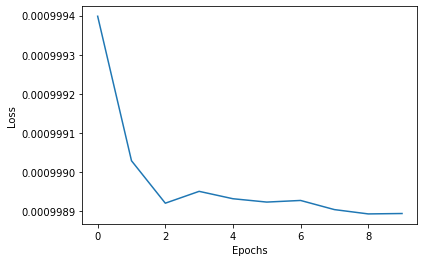

In [74]:
epochs = np.arange(10)

plt.plot(epochs, loss)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Algorithm CV Experiments

#### CV For Best Hyper-Parameters

In [82]:
# Get stats
hps = get_hp_combs(L_RATES, REGS).tolist()
labels = [-1, 1]

cvv_stats, _ = five_fold_CV(
    k_datasets=ff_data,
    labels=labels,
    hyperparams=hps,
    epochs=CV_EPOCHS
)

In [83]:
# Print Stats
print("Accuracy statistics from five-fold cross-validation:\n")
print("learning rate 'r' | C\t\t| five-fold mean | five-fold std")
for (r, C), (mean, std) in cvv_stats.items():
    print(f"r={r}\t\t  | C={C}\t| {np.round(mean, 3)}\t\t | {np.round(std, 3)}")


Accuracy statistics from five-fold cross-validation:

learning rate 'r' | C		| five-fold mean | five-fold std
r=1.0		  | C=0.0001	| 0.697		 | 0.099
r=0.1		  | C=0.0001	| 0.78		 | 0.004
r=0.01		  | C=0.0001	| 0.78		 | 0.004
r=0.001		  | C=0.0001	| 0.78		 | 0.004
r=0.0001		  | C=0.0001	| 0.78		 | 0.004
r=1.0		  | C=0.001	| 0.658		 | 0.218
r=0.1		  | C=0.001	| 0.78		 | 0.004
r=0.01		  | C=0.001	| 0.78		 | 0.004
r=0.001		  | C=0.001	| 0.78		 | 0.004
r=0.0001		  | C=0.001	| 0.78		 | 0.004
r=1.0		  | C=0.01	| 0.652		 | 0.166
r=0.1		  | C=0.01	| 0.78		 | 0.004
r=0.01		  | C=0.01	| 0.78		 | 0.004
r=0.001		  | C=0.01	| 0.78		 | 0.004
r=0.0001		  | C=0.01	| 0.78		 | 0.004
r=1.0		  | C=0.1	| 0.78		 | 0.004
r=0.1		  | C=0.1	| 0.78		 | 0.004
r=0.01		  | C=0.1	| 0.78		 | 0.004
r=0.001		  | C=0.1	| 0.78		 | 0.004
r=0.0001		  | C=0.1	| 0.78		 | 0.004
r=1.0		  | C=1.0	| 0.78		 | 0.004
r=0.1		  | C=1.0	| 0.78		 | 0.004
r=0.01		  | C=1.0	| 0.78		 | 0.004
r=0.001		  | C=1.0	| 0.78		 | 0.004
r=0.0001		  | 

#### Best Hyperparameters CV Experiments Discussion

The SVM classifiers above were trained for at most 50 epochs and training was allowed to stop if the loss was sampled to converge within a tolerance of 1e-4. From looking at the table above, the best five-fold accuracy was 0.798 (SD = 0.003) when the learning-rate r = 1e-2 and regularization C = 10. These hyperparameters will be used to train the SVM in the next section.

### Implementation Precision, Recall, and $F_1$ Scores

In [ ]:
# SVM Classifier trained over 50 epochs w/ best hyperparameters
R_LR_BEST = 1e-2
C_LR_BEST = 10

In [100]:
# Train SVM Classifier
model_svm = SVM(labels, r=R_SVM_BEST, C=C_SVM_BEST, epochs=5, exit_on_converge=True)
loss_svm = model_svm.train(X_train, Y_train)

In [101]:
# Print accuracy on testing set.
acc = calc_acc(model_svm.predict(X_test), Y_test)
print(f"Accuracy on training set: {acc} w/ r = {R_SVM_BEST} and C = {C_SVM_BEST}.")

Accuracy on training set: 0.8051 w/ r = 0.01 and C = 10.


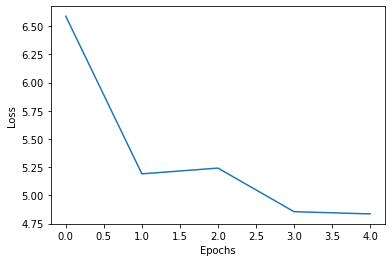

In [102]:
# Plot Loss function of SVM w/ 'best' Hyperparameters
epochs_svm = np.arange(len(loss_svm))

plt.plot(epochs_svm, loss_svm)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [103]:
# Print true positive, false positive, false negative, and true negative scores.
tp_svm, fp_svm, fn_svm, tn_svm = get_prediction_errors(Y_test, model_svm.predict(X_test))

In [104]:
# Print F_1, recall, and precision scores
p_svm = calc_precision(tp_svm, fp_svm)
rec_svm = calc_recall(tp_svm, fn_svm)
f1_svm = calc_f1(p_svm, rec_svm)

print(f"Precision Score: {p_svm}")
print(f"Recall Score: {rec_svm}")
print(f"F1 Score: {f1_svm}")

Precision Score: 0.6984352773826458
Recall Score: 0.2203770197486535
F1 Score: 0.33503923575571476


#### Discussion

Currently, at the hyperparameters I listed, my SVM classifier is right most of the time when it predicts a positive but it is missing most of all actual positives; hence, the low reported $F_1$ score. Maybe if I increased or decreased the five-fold CV epochs we might get a higher scoring model. Currently, the SVM classifier is not converging within 100 epochs (tol = 1e-4). I obtained the top $F_1$ score by only training the model with the "best" hyperparameters for 5 epochs. It seems that the data leans more towards negative examples so this could be a consequence of the data quality as well.

## 2.2 - Logistic Regression Implementation Experiments

### Implementation Details

I implemented a class in the file logistic_reg.py to represent my Logistic Regression (LR) classifier. I instantiated the weights to be random values such that -1e-8 $\leq w \leq$ 1e-8 . The dataset was shuffled at each epoch and I used a decaying learning rate $r_{t+1}= r_t / (1+t)$ . The Stochastic Gradient Descent algorithm was used to minimize the loss function on question 1 of this homework. The bias term was located at the beginning of the weight vector and ones were inserted into the beginning of the input data matrix to allow implicit calculations w/ the bias term. My LR assumed an L2 regularized cross-entropy loss.

### Demo - Logistic Regression Class

In [ ]:
# simple LR demo
labels = [-1, 1]
model = LogisticRegression(labels, r=L_RATES[0], sigma=TRADEOFF[2], epochs=100)
loss = model.train(X_train, Y_train)

Converged at epoch T=64


In [106]:
# print accuracy on training set.
acc = calc_acc(model.predict(X_train), Y_train)
print(f"Accuracy on training set: {acc} w/ tol = {model.tol}")

Accuracy on training set: 0.8125 w/ tol = 0.0001


### Loss Function Over 10 Epochs

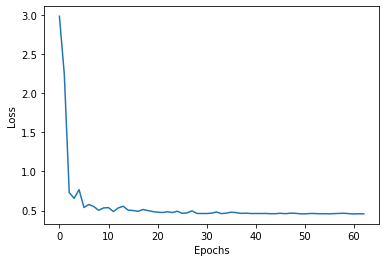

In [ ]:
epochs = np.arange(100)

plt.plot(epochs[0:63], loss[0:63]) # might need to edit this

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Algorithm CV Experiments

#### CV For Best Hyper-Parameters

In [109]:
# Get stats
hps = get_hp_combs(L_RATES, TRADEOFF).tolist()
labels = [-1, 1]

cvv_stats, _ = five_fold_CV(
    k_datasets=ff_data,
    labels=labels,
    hyperparams=hps,
    epochs=CV_EPOCHS
)

In [111]:
# Print Stats
print("Accuracy statistics from five-fold cross-validation:\n")
print("learning rate 'r' | s\t\t| five-fold mean | five-fold std")
for (r, s), (mean, std) in cvv_stats.items():
    print(f"r={r}\t\t  | s={s}\t| {np.round(mean, 3)}\t\t | {np.round(std, 3)}")


Accuracy statistics from five-fold cross-validation:

learning rate 'r' | s		| five-fold mean | five-fold std
r=1.0		  | s=0.1	| 0.78		 | 0.004
r=0.1		  | s=0.1	| 0.78		 | 0.004
r=0.01		  | s=0.1	| 0.78		 | 0.004
r=0.001		  | s=0.1	| 0.78		 | 0.004
r=0.0001		  | s=0.1	| 0.78		 | 0.004
r=1.0		  | s=1.0	| 0.78		 | 0.004
r=0.1		  | s=1.0	| 0.78		 | 0.004
r=0.01		  | s=1.0	| 0.78		 | 0.004
r=0.001		  | s=1.0	| 0.78		 | 0.004
r=0.0001		  | s=1.0	| 0.78		 | 0.004
r=1.0		  | s=10.0	| 0.682		 | 0.192
r=0.1		  | s=10.0	| 0.799		 | 0.009
r=0.01		  | s=10.0	| 0.797		 | 0.004
r=0.001		  | s=10.0	| 0.794		 | 0.003
r=0.0001		  | s=10.0	| 0.794		 | 0.004
r=1.0		  | s=100.0	| 0.735		 | 0.056
r=0.1		  | s=100.0	| 0.73		 | 0.069
r=0.01		  | s=100.0	| 0.818		 | 0.003
r=0.001		  | s=100.0	| 0.817		 | 0.002
r=0.0001		  | s=100.0	| 0.817		 | 0.002
r=1.0		  | s=1000.0	| 0.696		 | 0.171
r=0.1		  | s=1000.0	| 0.69		 | 0.085
r=0.01		  | s=1000.0	| 0.774		 | 0.037
r=0.001		  | s=1000.0	| 0.817		 | 0.002
r=0.0001

#### Best Hyperparameters CV Experiments Discussion

The Logistic Regression (LR) classifiers above were trained for at most 25 epochs and training was allowed to stop if the loss was sampled to converge within a tolerance of 1e-4. From looking at the table above, the best five-fold mean average of 0.82 occurred several times amongst 5 hyperparameter pairs. I selected r =1e-3 and $\sigma$=1e3 at random to train the LR classifier in the next section.

### Implementation Precision, Recall, and $F_1$ Scores

In [114]:
# LR Classifier trained over 50 epochs w/ best hyperparameters
R_LR_BEST = 1e-3
S_LR_BEST = 1e3

In [115]:
# Train LR Classifier
model_LR = LogisticRegression(labels, r=R_LR_BEST, sigma=S_LR_BEST, epochs=EPOCHS, exit_on_converge=True)
loss_LR = model_LR.train(X_train, Y_train)

Converged at epoch T=16


In [116]:
# Print accuracy on testing set.
acc = calc_acc(model_LR.predict(X_test), Y_test)
print(f"Accuracy on training set: {acc} w/ r = {R_LR_BEST} and C = {S_LR_BEST}.")

Accuracy on training set: 0.8189 w/ r = 0.001 and C = 1000.0.


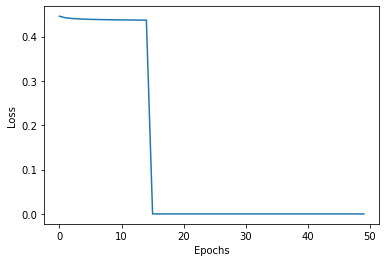

In [117]:
# Plot Loss function of LR w/ 'best' Hyperparameters
epochs_LR = np.arange(len(loss_LR))

plt.plot(epochs_LR, loss_LR)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [118]:
# Print true positive, false positive, false negative, and true negative scores.
tp_LR, fp_LR, fn_LR, tn_LR = get_prediction_errors(Y_test, model_LR.predict(X_test))

In [119]:
# Print F_1, recall, and precision scores
p_LR = calc_precision(tp_LR, fp_LR)
rec_LR = calc_recall(tp_LR, fn_LR)
f1_LR = calc_f1(p_LR, rec_LR)

print(f"Precision Score: {p_LR}")
print(f"Recall Score: {rec_LR}")
print(f"F1 Score: {f1_LR}")

Precision Score: 0.7022308438409312
Recall Score: 0.3249551166965889
F1 Score: 0.44430806996011046


#### Discussion

Currently, at the hyperparameters I listed, my LR classifier is right most of the time when it predicts a positive but it is missing about a third of all actual positives (an improvement over the SVM classifier). Therefore, my LR classifier is doing decently well especially when comparing to the performance of my SVM classifier above. Some experimentation w/ the other four optimal hyperparameter pairs might increase the $F_1$ score but I did not test other pairs for this report.